In [ ]:
# !pip install plotly
# !pip install matplotlib==3.5.0

In [1]:
import pandas as pd
import numpy as np
import glob
from tqdm import tqdm, trange
#import pickle5 as pickle


import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import plotly.express as px
from difflib import SequenceMatcher
import seaborn as sns

In [2]:
def millions(x, pos):
    """The two args are the value and tick position."""
    return '{:1.1f}M'.format(x*1e-6)


In [3]:
all_data = pd.read_pickle('data/morbilidad_global_ts.csv')

In [4]:
diagnostics_tag = np.unique(all_data['DISEASE_GROUP'])

cmap = cm.get_cmap('tab20b', 256)
colorsb = cmap(np.linspace(0, 1, 20))
cmap = cm.get_cmap('tab20c', 256)
colorsc = cmap(np.linspace(0, 1, 20))[8:-4]

colors = list(colorsc)+list(colorsb)
# new_colors = []
# for i in range(len(colorsc)):
#     new_colors.append(colorsc[i])
#     new_colors.append(colorsb[i])

dict_colors = {}
counter = 0
for d in diagnostics_tag:
    x=colors[counter]
    dict_colors[d]=matplotlib.colors.rgb2hex(x)
    counter+=1

In [5]:
all_data.head()

,DATE,YEAR,MONTH,STATE,PROVINCE,DISTRICT,SECTOR,CATEGORY,CATEGORY2,CO_IPRESS,...,DIAGNOSIS_ID,QTY_PEOPLE_SERVED,DISEASE,DISEASE_GROUP,COD_IPRESS,x,y,SECTOR_R,TYPE,IS_LIMA
0,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVATE,II-2,II,00015610,...,R10.2,10,PELVIC AND PERINEAL PAIN,"Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,True
1,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVATE,II-2,II,00015610,...,R10.4,11,UNIDENTIFIED,"Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,True
2,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVATE,II-2,II,00015610,...,R11.X,3,UNIDENTIFIED,"Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,True
3,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVATE,II-2,II,00015610,...,R16.0,1,"HEPATOMEGALY, NOT ELSEWHERE CLASSIFIED","Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,True
4,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVATE,II-2,II,00015610,...,R42.X,1,UNIDENTIFIED,"Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,True


### Forecast

In [6]:
# import plotly.io as pio 
# import plotly.graph_objects as go

from pycaret.time_series import *

C:\Users\johnk\.conda\envs\pycart_ts\lib\site-packages\sktime\utils\validation\series.py:21: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
C:\Users\johnk\.conda\envs\pycart_ts\lib\site-packages\sktime\forecasting\base\_fh.py:18: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  RELATIVE_TYPES = (pd.Int64Index, pd.RangeIndex)
C:\Users\johnk\.conda\envs\pycart_ts\lib\site-packages\sktime\forecasting\base\_fh.py:19: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  ABSOLUTE_TYPES = (pd.Int64Index, pd.RangeIndex, pd.DatetimeIndex, pd.PeriodIndex)
C:\Users\johnk\.conda\envs\pycart_ts\lib\site-p

In [7]:
#!pip install pycaret-ts-alpha
#!pip install pycaret[full]

In [8]:
import pycaret as pyct

In [9]:
CATEGORIA_STUDIO = 'I'

In [10]:
data_temp = all_data[all_data['CATEGORY2']==CATEGORIA_STUDIO]
data_temp =  data_temp.groupby(['DATE', 'SECTOR']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

data_temp['QTY_PEOPLE_SERVED'] =data_temp['QTY_PEOPLE_SERVED'].mask((data_temp['DATE'].dt.year==2018) & (data_temp['DATE'].dt.month==4),data_temp['QTY_PEOPLE_SERVED'].median())

data_temp = data_temp.pivot_table(index=['DATE'], 
                                  columns=['SECTOR'], 
                                  values='QTY_PEOPLE_SERVED').fillna(0)
data_temp = data_temp.reset_index()

In [11]:
private_max = data_temp['PRIVATE'].mean() + 1*data_temp['PRIVATE'].std()
private_min = data_temp['PRIVATE'].mean() - 1*data_temp['PRIVATE'].std()

data_temp['PRIVATE_PURE'] = data_temp['PRIVATE'].apply(lambda x :
                                                       0 if (private_min>x or
                                                             private_max<x)
                                                       else x)

public_max = data_temp['PUBLIC'].mean() + 1*data_temp['PUBLIC'].std()
public_min = data_temp['PUBLIC'].mean() - 1*data_temp['PUBLIC'].std()

data_temp['PUBLIC_PURE'] = data_temp['PUBLIC'].apply(lambda x :
                                                       0 if (public_min>x or
                                                             public_max<x)
                                                       else x)



In [28]:
x = data_temp['PRIVATE'].values
y = data_temp['DATE'].values

<AxesSubplot:>

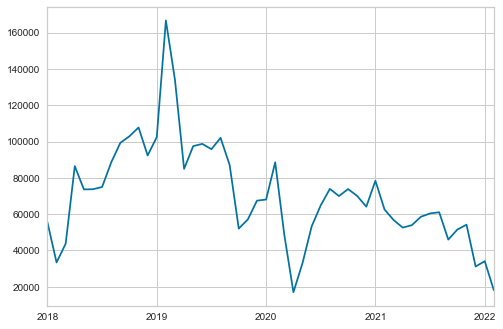

In [29]:
df_series_pre = pd.Series(data = x, index = y)
df_series_pre.plot()

In [12]:
post_pandemic_df = data_temp[(data_temp['DATE'] > '2020-03')]
pre_pandemic_df = data_temp[~(data_temp['DATE'] > '2020-03')]

post_pandemic_df

SECTOR,DATE,PRIVATE,PUBLIC,PRIVATE_PURE,PUBLIC_PURE
27,2020-04-01,16991.0,16231.0,0.0,0.0
28,2020-05-01,33071.0,23259.0,0.0,0.0
29,2020-06-01,53234.0,42370.0,53234.0,0.0
30,2020-07-01,64858.0,59335.0,64858.0,0.0
31,2020-08-01,73911.0,66832.0,73911.0,0.0
32,2020-09-01,69955.0,64905.0,69955.0,0.0
33,2020-10-01,73812.0,70606.0,73812.0,70606.0
34,2020-11-01,69988.0,86098.0,69988.0,86098.0
35,2020-12-01,64110.0,86790.0,64110.0,86790.0
36,2021-01-01,78381.0,82445.0,78381.0,82445.0


#### PRIVATE

<AxesSubplot:>

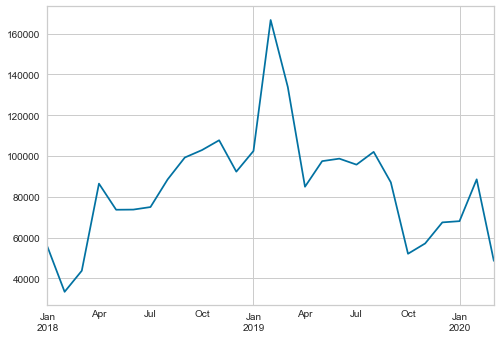

In [18]:
index = pre_pandemic_df['DATE'].values
data_to = pre_pandemic_df['PRIVATE'].values
df_series_pre = pd.Series(data = data_to, index = index)
df_series_pre.plot()

<AxesSubplot:>

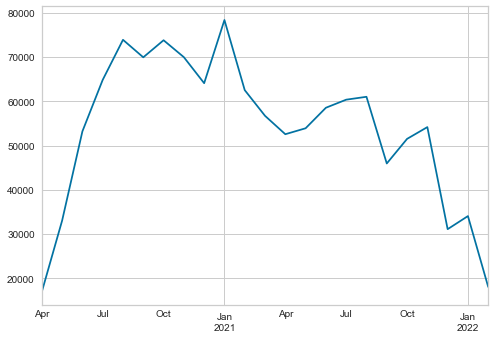

In [19]:
index = post_pandemic_df['DATE'].values
data_to = post_pandemic_df['PRIVATE'].values
df_series = pd.Series(data = data_to, index = index)
df_series.plot()

,Description,Value
0,session_id,8288
1,Target,Time Series
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Data shape,"(23, 1)"
5,Train data shape,"(22, 1)"
6,Test data shape,"(1, 1)"
7,Fold Generator,ExpandingWindowSplitter
8,Fold Number,7
9,Enforce Prediction Interval,False


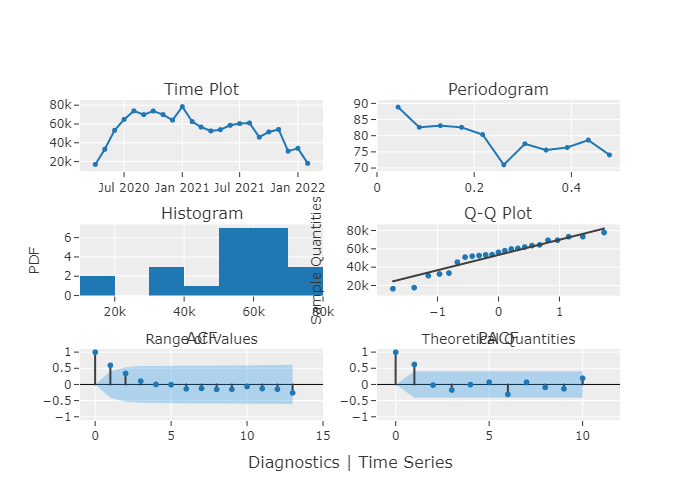

In [15]:

setup(data=df_series, fh = 1 , fold = 7)

plot_model(plot = 'diagnostics', 
           fig_kwargs={'renderer': 'png'})

In [16]:
plot_model(plot = 'decomp_stl', 
           fig_kwargs={'renderer': 'png'})

STL Decomposition is not supported for time series that have a seasonal period < 2. The seasonal period computed/provided was 1.


In [23]:
best_baseline_models = compare_models( sort='MAE', errors = 'raise', verbose =False) # Media absolute error
best_baseline_models

ARIMA()

In [21]:
#best_baseline_models = 'auto_arima'
the_model = create_model(best_baseline_models)
print(the_model)

tuned_model= tune_model(the_model)
print(tuned_model)

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE
0,2021-06,3057.9763,3057.9763,0.0506,0.0520,0.3553,0.2964
1,2021-07,1238.8389,1238.8389,0.0203,0.0201,0.1519,0.1241
2,2021-08,15633.1010,15633.1010,0.3400,0.2906,2.0343,1.6176
3,2021-09,2910.5473,2910.5473,0.0565,0.0581,0.3585,0.2893
4,2021-10,15192.1456,15192.1456,0.2803,0.3260,1.9047,1.5398
5,2021-11,25907.9637,25907.9637,0.8320,0.5876,3.3661,2.6925
6,2021-12,741.9741,741.9741,0.0218,0.0220,0.0877,0.0693
Mean,nan,9240.3639,9240.3639,0.2288,0.1938,1.1798,0.9470
SD,nan,9012.9685,9012.9685,0.2743,0.2000,1.1735,0.9374


ARIMA()


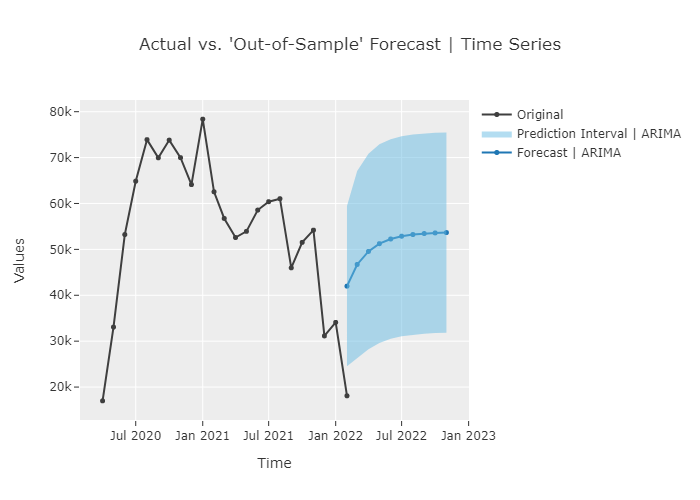

In [24]:
final_best = finalize_model(the_model)
predict_model(final_best, fh = 1)

abc = plot_model(the_model, 
           plot = 'forecast', 
           data_kwargs = {'fh' : 10}, 
           fig_kwargs={'renderer': 'png'})

In [ ]:
np.mean(df_series_pre)

In [ ]:
setup(data=df_series_pre)
best_baseline_models = compare_models(sort='MAE', errors = 'raise', verbose =False) # Media absolute error
print(best_baseline_models)

In [ ]:
the_model = create_model(best_baseline_models)
print(the_model)

tuned_model= tune_model(the_model)
print(tuned_model)

In [ ]:
final_best = finalize_model(the_model)
predict_model(final_best, fh = 5)

plot_model(the_model, 
           plot = 'forecast', 
           data_kwargs = {'fh' : 5}, 
           fig_kwargs={'renderer': 'png'})

#### PUBLIC

In [ ]:
index = post_pandemic_df['DATE'].values
data_to = post_pandemic_df['PUBLIC'].values
df_series = pd.Series(data = data_to, index = index)

index = pre_pandemic_df['DATE'].values
data_to = pre_pandemic_df['PUBLIC'].values
df_series_pre = pd.Series(data = data_to, index = index)

df_series.plot()

In [ ]:
print("Media: "+str(np.mean(df_series_pre)))

In [ ]:
from pycaret.time_series import *
setup(data=df_series)

plot_model(plot = 'diagnostics', 
           fig_kwargs={'renderer': 'png'})

In [ ]:
plot_model(plot = 'diagnostics')

In [ ]:
best_baseline_models = compare_models(sort='MAE', errors = 'raise', verbose =False) # Media absolute error
best_baseline_models

In [ ]:
#best_baseline_models = 'auto_arima'
the_model = create_model(best_baseline_models)
print(the_model)

tuned_model= tune_model(the_model)
print(tuned_model)

In [ ]:
final_best = finalize_model(best_baseline_models)
final_best = finalize_model(the_model)
predict_model(final_best, fh = 5)

plot_model(the_model, 
           plot = 'forecast', 
           data_kwargs = {'fh' : 5}, 
           fig_kwargs={'renderer': 'png'})

In [ ]:
x =  list(data_to) + list(predict_model(final_best, fh = 5)['y_pred'])
x

In [ ]:
post_pandemic_df.head(50)

In [ ]:
import pandas as pd
from pycaret.datasets import get_data
data = get_data('pycaret_downloads')
data['Date'] = pd.to_datetime(data['Date'])
data = data.groupby('Date').sum()
data = data.asfreq('D')
data.head()

In [ ]:
# plot the data
data.plot()

In [ ]:
# with functional API
from pycaret.time_series import *
setup(data, fh = 7, fold = 3, session_id = 123)

In [ ]:
check_stats()

In [ ]:
# functional API
plot_model(plot = 'ts', 
           fig_kwargs={'renderer': 'png'})

In [ ]:
# cross-validation plot
plot_model(plot = 'cv', 
           fig_kwargs={'renderer': 'png'})

In [ ]:
# ACF plot
plot_model(plot = 'acf', 
           fig_kwargs={'renderer': 'png'})

In [ ]:
# Decomposition plot
plot_model(plot = 'decomp_stl', 
           fig_kwargs={'renderer': 'png'})

In [ ]:
# functional API
best = compare_models()

In [ ]:
best

In [ ]:
# create fbprophet model
best_model = create_model(best)
print(best_model)

In [ ]:
plot_model(best, plot = 'forecast', 
           fig_kwargs={'renderer': 'png'})